In [1]:
# HIDDEN
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

from pathlib import Path
from ds100_utils import fetch_and_cache
from datetime import datetime
from IPython.display import display
import yaml

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [20]:
# HIDDEN
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]

    row_arg = (0, len(df), nrows) if len(df) > nrows else fixed(0)
    col_arg = ((0, len(df.columns), ncols)
               if len(df.columns) > ncols else fixed(0))
    
    interact(peek, row=row_arg, col=col_arg)
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

# Data

In [3]:
# From Lecture 4: current members of congress
base_url = 'https://github.com/unitedstates/congress-legislators/raw/master/'
current_path = 'legislators-current.yaml'
f = fetch_and_cache(base_url + current_path, current_path)
current_data = yaml.safe_load(open(f))

def birthdays(data):
    return pd.DataFrame(
        columns=['leg_id', 'first', 'last', 'gender', 'terms', 'birthday'],
        data=[[x['id']['bioguide'], 
               x['name']['first'],
               x['name']['last'],
               x['bio']['gender'],
               len(x['terms']),
               pd.to_datetime(x['bio'].get('birthday'), yearfirst=True)
              ] for x in data])

current_legs = birthdays(current_data)
current_legs

Using cached version that was downloaded (UTC): Tue Jul  9 16:06:45 2019


,leg_id,first,last,gender,terms,birthday
0,B000944,Sherrod,Brown,M,10,1952-11-09
1,C000127,Maria,Cantwell,F,5,1958-10-13
2,C000141,Benjamin,Cardin,M,13,1943-10-05
...,...,...,...,...,...,...
536,M001197,Martha,McSally,F,3,1966-03-22
537,G000592,Jared,Golden,M,1,1982-07-25
538,K000395,Fred,Keller,M,1,1965-10-23


In [4]:
# Past members of congress
past_path = 'legislators-historical.yaml'
f = fetch_and_cache(base_url + past_path, past_path)
past_data = yaml.safe_load(open(f))

past_legs = birthdays(past_data)
past_legs

Downloading... Done!


,leg_id,first,last,gender,terms,birthday
0,B000226,Richard,Bassett,M,1,1745-04-02
1,B000546,Theodorick,Bland,M,1,1742-03-21
2,B001086,Aedanus,Burke,M,1,1743-06-16
...,...,...,...,...,...,...
11972,J000303,Brenda,Jones,F,1,1959-10-24
11973,M001179,Tom,Marino,M,5,1952-08-15
11974,J000255,Walter,Jones,M,13,1943-02-10


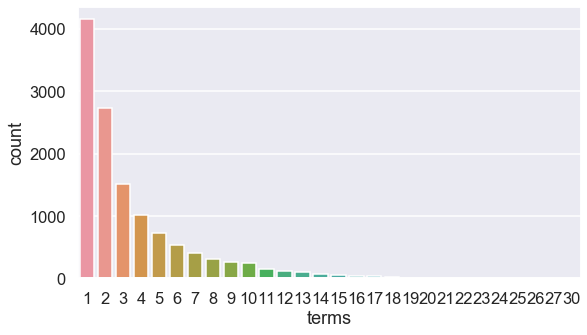

In [105]:
plt.figure(figsize=(9, 5))
legs = pd.concat([past_legs, current_legs]).reset_index(drop=True)
assert legs.shape[0] == len(legs['leg_id'].unique()) # No repeats
sns.countplot(legs['terms'])

# Study Design

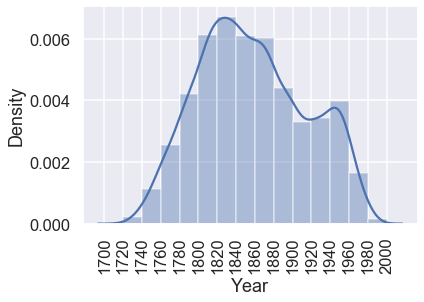

In [6]:
bins = np.linspace(1700, 2000, 16)
sns.distplot(legs['birthday'].dropna().dt.year, bins=bins)
plt.xlabel('Year');
plt.xticks(bins, rotation=90)
plt.ylabel('Density');

## Question
According to the histogram, about what proportion of all members of congress were born between 1840 and 1880?

In [7]:
0.006 * (40)

0.24

## Question
How do you compute the exact proportion using Pandas?

In [8]:
# Solution 1
bday = legs['birthday']
sum((bday.dt.year >= 1840) & (bday.dt.year < 1880)) / len(bday)

0.2316605401949816

In [9]:
# Solution 2
sum((bday.dt.year >= 1840) & (bday.dt.year < 1880)) / len(bday.dropna())

0.24237103921076833

In [10]:
bday.isnull().value_counts()

False    11961
True       553
Name: birthday, dtype: int64

In [11]:
sum(bday.isnull()) / len(bday)

0.04419050663257152

# Question
How do you think the missing birthdays bias the birthyear distribution?

```
(a) Low bins have too little density
(b) High bins have too little density
(c) All bins have too little density
(d) Impossible to tell
```

Could inspecting the data further help answer this question?

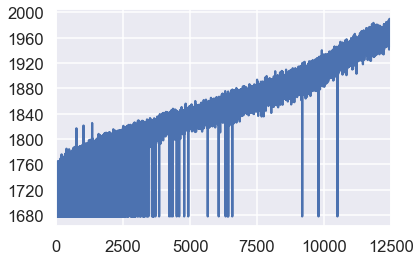

In [12]:
legs['birthday'].plot();

## Question

How would you better visualize the rate of missing values?

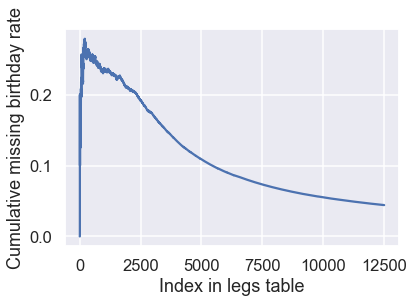

In [13]:
plt.plot(np.cumsum(bday.isnull())/np.arange(len(bday)));
plt.xlabel('Index in legs table')
plt.ylabel('Cumulative missing birthday rate');

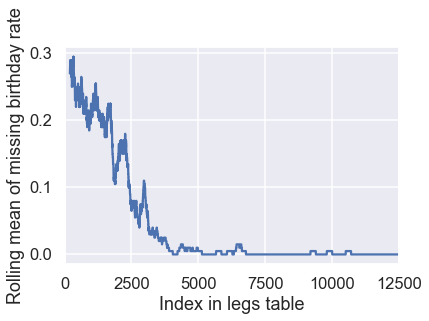

In [14]:
bday.isnull().rolling(200).mean().plot();
plt.xlabel('Index in legs table')
plt.ylabel('Rolling mean of missing birthday rate');

# Data Cleaning

In [15]:
past_data[0]

{'id': {'bioguide': 'B000226',
  'govtrack': 401222,
  'icpsr': 507,
  'wikipedia': 'Richard Bassett (politician)',
  'wikidata': 'Q518823',
  'google_entity_id': 'kg:/m/02pz46'},
 'name': {'first': 'Richard', 'last': 'Bassett'},
 'bio': {'birthday': '1745-04-02', 'gender': 'M'},
 'terms': [{'type': 'sen',
   'start': '1789-03-04',
   'end': '1793-03-03',
   'state': 'DE',
   'class': 2,
   'party': 'Anti-Administration'}]}

## Question

What will be the granularity of a table that includes term information?

In [16]:
past_data[10000]

{'id': {'bioguide': 'H000717',
  'govtrack': 405569,
  'icpsr': 4518,
  'wikipedia': 'Elmer J. Holland',
  'house_history': 15170,
  'wikidata': 'Q5366586',
  'google_entity_id': 'kg:/m/0dn46g'},
 'name': {'first': 'Elmer', 'middle': 'Joseph', 'last': 'Holland'},
 'bio': {'birthday': '1894-01-08', 'gender': 'M'},
 'terms': [{'type': 'rep',
   'start': '1941-01-03',
   'end': '1943-01-03',
   'state': 'PA',
   'district': 33,
   'party': 'Democrat'},
  {'type': 'rep',
   'start': '1955-01-05',
   'end': '1957-01-03',
   'state': 'PA',
   'district': 30,
   'party': 'Democrat'},
  {'type': 'rep',
   'start': '1957-01-03',
   'end': '1959-01-03',
   'state': 'PA',
   'district': 30,
   'party': 'Democrat'},
  {'type': 'rep',
   'start': '1959-01-07',
   'end': '1961-01-03',
   'state': 'PA',
   'district': 30,
   'party': 'Democrat'},
  {'type': 'rep',
   'start': '1961-01-03',
   'end': '1963-01-03',
   'state': 'PA',
   'district': 30,
   'party': 'Democrat'},
  {'type': 'rep',
   'star

In [18]:
columns=['leg_id', 'term', 'type', 'start', 'end', 'state', 'party']
data = []
for x in past_data + current_data:
    for i, t in enumerate(x['terms']):
        data.append([
            x['id']['bioguide'], 
            i + 1,
            t['type'],
            pd.to_datetime(t['start'], yearfirst=True),
            pd.to_datetime(t['end'], yearfirst=True),
            t['state'],
            t.get('party'),
        ])
        
terms = pd.DataFrame(columns=columns, data=data)
terms

,leg_id,term,type,start,end,state,party
0,B000226,1,sen,1789-03-04,1793-03-03,DE,Anti-Administration
1,B000546,1,rep,1789-03-04,1791-03-03,VA,None
2,B001086,1,rep,1789-03-04,1791-03-03,SC,None
...,...,...,...,...,...,...,...
43998,M001197,3,sen,2019-01-03,2021-01-03,AZ,Republican
43999,G000592,1,rep,2019-01-03,2021-01-03,ME,Democrat
44000,K000395,1,rep,2019-06-03,2021-01-03,PA,Republican


In [22]:
terms.shape

(44001, 7)

In [26]:
display_df(
    terms.groupby(['leg_id', 'start']).size().sort_values(ascending=False).head(15),
    15
)

leg_id   start     
A000083  1881-12-05    2
S001073  1801-12-07    2
V000074  1811-11-04    2
M000034  1815-12-04    2
W000238  1827-12-03    2
L000393  1893-08-07    2
C000150  1861-07-04    2
A000130  1889-12-02    2
G000414  1857-12-07    2
B000769  1905-12-04    2
R000063  1851-12-01    2
B000434  1813-05-24    2
G000071  1955-01-05    1
         1953-01-03    1
         1951-01-03    1
dtype: int64

In [28]:
display_df(terms['party'].value_counts(), 30)

Democrat                      20447
Republican                    18868
Whig                           1203
Jackson                         880
Federalist                      819
Adams                           256
Ind. Republican-Democrat        128
American                         84
Anti Masonic                     77
Unionist                         77
Populist                         68
Anti Jacksonian                  56
Independent                      46
Progressive                      43
Jacksonian                       39
                              ...  
Democrat-Liberal                  1
Liberal                           1
Pro-administration                1
Jacksonian Republican             1
Republican-Conservative           1
Progressive Republican            1
Free Silver                       1
Liberty                           1
Nonpartisan                       1
Adams Democrat                    1
Democratic and Union Labor        1
Union Democrat              

In [30]:
display_df(terms['party'].value_counts().head(8), 8)

Democrat                    20447
Republican                  18868
Whig                         1203
Jackson                       880
Federalist                    819
Adams                         256
Ind. Republican-Democrat      128
American                       84
Name: party, dtype: int64

## Question

How many terms were under the American party and smaller parties?

In [31]:
sum(terms['party'].value_counts().loc['American':])

941

In [32]:
sum(terms['party'].value_counts().iloc[7:])

941

In [33]:
terms['party'].isnull().value_counts()

False    43542
True       459
Name: party, dtype: int64

# Question

What proportion of all members of congress ever changed parties?

In [34]:
parties = (terms['party']
           .groupby(terms['leg_id'])
           .agg(lambda s: len(set(s)))) # Also .nunique()

parties.value_counts()

1    11657
2      694
3      146
4       14
5        2
6        1
Name: party, dtype: int64

In [35]:
sum(parties > 1) / len(parties)

0.06848329870544989

In [36]:
counts = terms.groupby('leg_id').nunique()
counts['party'].value_counts()

1    11588
2      643
0      167
3      101
4       12
5        2
6        1
Name: party, dtype: int64

In [37]:
counts['state'].value_counts()

1    12454
2       58
3        2
Name: state, dtype: int64

# Visualization

In [41]:
a = terms.groupby('start')
starts = a.nunique()
starts

,leg_id,term,type,start,end,state,party
start,,,,,,,
1789-03-04,90,1,2,1,4,13,6
1790-01-01,5,1,1,1,4,3,3
1791-03-04,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...
2019-01-04,1,1,1,1,1,1,1
2019-01-08,1,1,1,1,1,1,1
2019-06-03,1,1,1,1,1,1,1


## Question

What visualization will help determine which term starts follow from national elections?

```
(a) A histogram of start values in terms
(b) A line plot of start values in terms
(c) A histogram of leg_id values in starts
(d) A line plot of leg_id values in starts
```

How would you use this visualization to focus future analysis on the composition of congress after each national election?

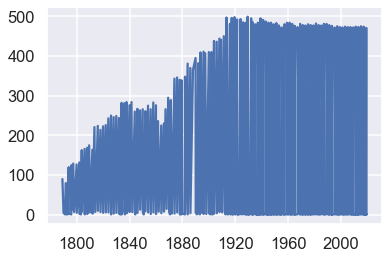

In [42]:
plt.plot(starts['leg_id']);

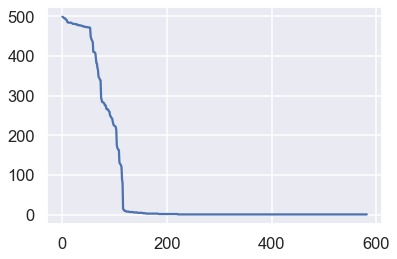

In [43]:
plt.plot(starts['leg_id'].sort_values(ascending=False).values);

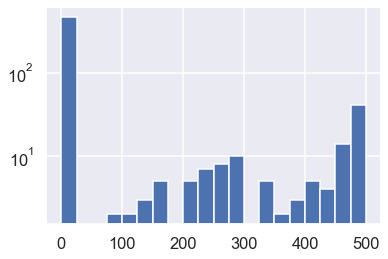

In [44]:
plt.hist(starts['leg_id'], bins=20, log=True);

In [45]:
sum((starts['leg_id'] > 15) & (starts['leg_id'] < 80))

0

In [46]:
starts[starts['leg_id'] > 15].index

DatetimeIndex(['1789-03-04', '1791-10-24', '1793-12-02', '1795-12-07',
               '1797-05-15', '1799-12-02', '1801-12-07', '1803-10-17',
               '1805-12-02', '1807-10-26',
               ...
               '2001-01-03', '2003-01-07', '2005-01-04', '2007-01-04',
               '2009-01-06', '2011-01-05', '2013-01-03', '2015-01-06',
               '2017-01-03', '2019-01-03'],
              dtype='datetime64[ns]', name='start', length=116, freq=None)

In [47]:
biannual = pd.to_datetime([f'01-25-{n}' for n in range(1941, 2020, 2)])
biannual

DatetimeIndex(['1941-01-25', '1943-01-25', '1945-01-25', '1947-01-25',
               '1949-01-25', '1951-01-25', '1953-01-25', '1955-01-25',
               '1957-01-25', '1959-01-25', '1961-01-25', '1963-01-25',
               '1965-01-25', '1967-01-25', '1969-01-25', '1971-01-25',
               '1973-01-25', '1975-01-25', '1977-01-25', '1979-01-25',
               '1981-01-25', '1983-01-25', '1985-01-25', '1987-01-25',
               '1989-01-25', '1991-01-25', '1993-01-25', '1995-01-25',
               '1997-01-25', '1999-01-25', '2001-01-25', '2003-01-25',
               '2005-01-25', '2007-01-25', '2009-01-25', '2011-01-25',
               '2013-01-25', '2015-01-25', '2017-01-25', '2019-01-25'],
              dtype='datetime64[ns]', freq=None)

## Question

What values/distributions should be visualized to determine whether the members of congress are older now than they used to be?

## Question

Using SQL, build a table of (term, election_date) pairs that contains the age of the person serving each term.

In [48]:
import sqlite3
conn = sqlite3.connect(':memory:')
terms.to_sql('terms', conn)
legs.to_sql('legs', conn)
pd.DataFrame({'election': biannual}).to_sql('elections', conn)
for exp in conn.execute('SELECT sql FROM sqlite_master'):
    print(exp[0])

CREATE TABLE "terms" (
"index" INTEGER,
  "leg_id" TEXT,
  "term" INTEGER,
  "type" TEXT,
  "start" TIMESTAMP,
  "end" TIMESTAMP,
  "state" TEXT,
  "party" TEXT
)
CREATE INDEX "ix_terms_index"ON "terms" ("index")
CREATE TABLE "legs" (
"index" INTEGER,
  "leg_id" TEXT,
  "first" TEXT,
  "last" TEXT,
  "gender" TEXT,
  "terms" INTEGER,
  "birthday" TIMESTAMP
)
CREATE INDEX "ix_legs_index"ON "legs" ("index")
CREATE TABLE "elections" (
"index" INTEGER,
  "election" TIMESTAMP
)
CREATE INDEX "ix_elections_index"ON "elections" ("index")


In [49]:
query = """
    SELECT election, state, party, 
           gender, first, last, 
           birthday, election - birthday AS age,
           CASE type WHEN "sen" THEN "Senate"
                     WHEN "rep" THEN "House" END AS chamber
    FROM terms, legs, elections 
    WHERE start <= election AND election < end AND 
          terms.leg_id=legs.leg_id
    """

df = pd.read_sql(query, conn)
df.head()

,election,state,party,gender,...,last,birthday,age,chamber
0,1941-01-25 00:00:00,MI,Democrat,M,...,Brown,1889-06-18 00:00:00,52.0,Senate
1,1941-01-25 00:00:00,SD,Democrat,M,...,Bulow,1869-01-13 00:00:00,72.0,Senate
2,1941-01-25 00:00:00,SC,Democrat,M,...,Byrnes,1882-05-02 00:00:00,59.0,Senate
3,1941-01-25 00:00:00,MS,Democrat,M,...,Harrison,1881-08-29 00:00:00,60.0,Senate
4,1941-01-25 00:00:00,IA,Democrat,M,...,Herring,1879-05-03 00:00:00,62.0,Senate


In [50]:
df['election'] = pd.to_datetime(df['election'], yearfirst=True)
df['birthday'] = pd.to_datetime(df['birthday'], yearfirst=True)
df.head()

,election,state,party,gender,...,last,birthday,age,chamber
0,1941-01-25,MI,Democrat,M,...,Brown,1889-06-18,52.0,Senate
1,1941-01-25,SD,Democrat,M,...,Bulow,1869-01-13,72.0,Senate
2,1941-01-25,SC,Democrat,M,...,Byrnes,1882-05-02,59.0,Senate
3,1941-01-25,MS,Democrat,M,...,Harrison,1881-08-29,60.0,Senate
4,1941-01-25,IA,Democrat,M,...,Herring,1879-05-03,62.0,Senate


In [51]:
df.shape

(21757, 9)

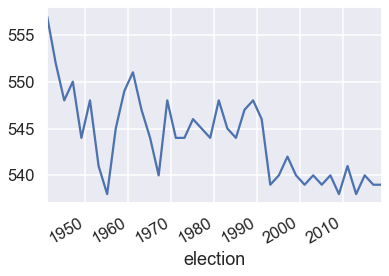

In [76]:
df.groupby('election').size().plot();s

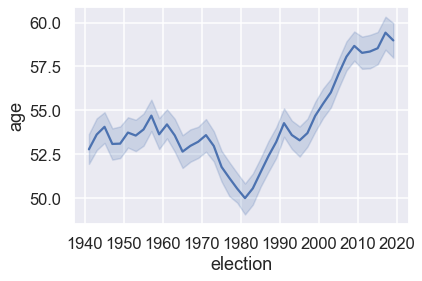

In [80]:
sns.lineplot(x='election', y='age', data=df);

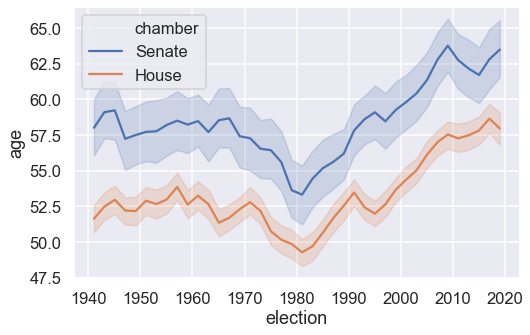

In [79]:
plt.figure(figsize=(8, 5))
sns.lineplot(x='election', y='age', hue='chamber', data=df);

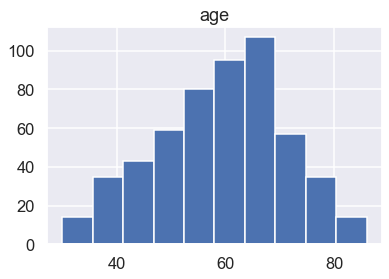

In [56]:
df[df['election'].dt.year == 2019].hist('age');

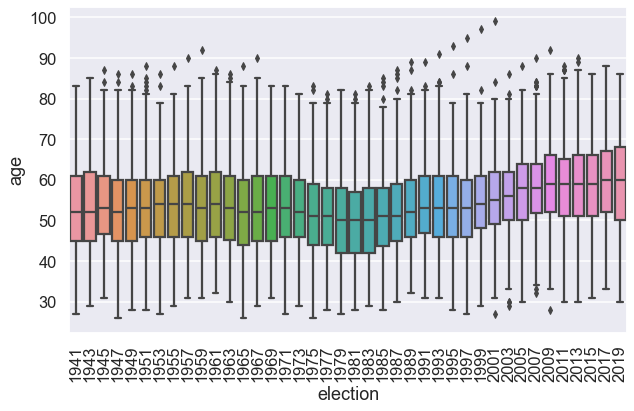

In [97]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='election', y='age', data=df)
ax.set_xticklabels(df['election'].dt.year.unique(), rotation=90)
labels = ax.get_xticklabels();

## Question

What does the boxplot reveal that was not obvious from the line plot?

Why does this boxplot have diagonal lines of outliers?